#### Import necessary libraries 

In [4]:
!pip install deepchem==2.6.1
!pip install rdkit-pypi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import numpy as np
import pandas as pd
from rdkit import Chem
import matplotlib.pyplot as plt
from rdkit.Chem import AllChem, DataStructs, PandasTools
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from deepchem import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid
import scipy
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from deepchem import metrics
import deepchem as dc
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import matthews_corrcoef
from deepchem.splits import RandomSplitter
from scipy.stats import ttest_ind

#### Read in the preprocessed BBB dataset from Adenot paper

In [6]:
bbb_df = pd.read_csv('adenot_processed.csv')

In [7]:
bbb_df.head()

,Drug,SMILES,permeable,0,1,2,3,4,5,6,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,ACEBUTOLOL,CCCC(=O)Nc1ccc(c(c1)C(C)=O)OCC(O)CNC(C)C,0,0,1,0,0,1,0,0,...,1,0,0,1,0,0,0,0,0,0
1,DACTINOMYCIN,CC(C)[C@H]1NC(=O)[C@@H](NC(=O)c2ccc(c3c2N=C2C(...,0,0,1,0,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0
2,ALDOSTERONE,C[C@@]12CCC(=O)C=C2CC[C@H]2C3CC[C@H](C(=O)CO)C...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,AMILORIDE,N\C(=N)\NC(=O)c1nc(c(nc1N)N)Cl,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AMIODARONE,CCCCc1oc2ccccc2c1C(=O)c1cc(c(c(c1)[I])OCCN(CC)...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Random Split

#### Data preprocessing

In [8]:
X = bbb_df.iloc[:,3:].copy()
y = bbb_df.iloc[:,2].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#### XGBoost

In [9]:
xgboost = XGBClassifier()
xgboost.fit(X_train, y_train)
# make predictions for test data
y_pred = xgboost.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.9518072289156626


#### Hyperparameter Optimization

In [10]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, ), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)
gsearch1.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(colsample_bytree=0.8, max_depth=5,
                                     n_estimators=140, nthread=4,
                                     subsample=0.8),
             n_jobs=4,
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 6, 2)},
             scoring='roc_auc')

In [11]:
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([ 9.98097687, 10.29310923, 10.68749347, 16.74652109, 16.34793601,
         16.30066681, 22.64082179, 19.20825524, 15.97847953, 23.56265812,
         20.25902858, 13.979915  ]),
  'std_fit_time': array([0.56339465, 0.30131467, 0.18017571, 0.36294324, 0.43442382,
         0.22285145, 0.27583062, 0.9208594 , 0.41803895, 0.71626915,
         0.58369527, 2.66997137]),
  'mean_score_time': array([0.16952586, 0.18349948, 0.19863167, 0.15344319, 0.14431801,
         0.17128434, 0.16873188, 0.12979903, 0.13205976, 0.13410559,
         0.1243392 , 0.07738671]),
  'std_score_time': array([0.0436664 , 0.02929742, 0.03660255, 0.05444701, 0.03776861,
         0.03914479, 0.02889581, 0.04278811, 0.01285011, 0.06005283,
         0.04747394, 0.05512258]),
  'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False, False, False],
         fill_value='?

In [12]:
param_test2 = {
 'max_depth':[2,3,4],
 'min_child_weight':[2,3,4]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4, cv=5)
gsearch2.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(colsample_bytree=0.8, max_depth=5,
                                     min_child_weight=2, n_estimators=140,
                                     nthread=4, subsample=0.8),
             n_jobs=4,
             param_grid={'max_depth': [2, 3, 4], 'min_child_weight': [2, 3, 4]},
             scoring='roc_auc')

In [13]:
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

({'mean_fit_time': array([ 6.8573132 ,  6.61616049,  8.04110117, 10.52056546,  9.16504622,
          9.46924376, 12.29066958, 11.9791152 , 10.32941022]),
  'std_fit_time': array([0.17646414, 0.30604514, 1.26710515, 1.16182441, 0.3500779 ,
         0.27513831, 0.80401574, 0.13659271, 2.46057805]),
  'mean_score_time': array([0.09098001, 0.12262526, 0.16911135, 0.12978106, 0.13581238,
         0.13788781, 0.16056395, 0.13798103, 0.07613368]),
  'std_score_time': array([0.0605434 , 0.04481447, 0.11602364, 0.0558043 , 0.01788534,
         0.01391724, 0.06380244, 0.02184138, 0.04961913]),
  'param_max_depth': masked_array(data=[2, 2, 2, 3, 3, 3, 4, 4, 4],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_min_child_weight': masked_array(data=[2, 3, 4, 2, 3, 4, 2, 3, 4],
               mask=[False, False, False, False, False, False, False, False,
                     False],


In [14]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4, cv=5)
gsearch3.fit(X_train,y_train)


GridSearchCV(cv=5,
             estimator=XGBClassifier(colsample_bytree=0.8, max_depth=4,
                                     min_child_weight=3, n_estimators=140,
                                     nthread=4, subsample=0.8),
             n_jobs=4, param_grid={'gamma': [0.0, 0.1, 0.2, 0.3, 0.4]},
             scoring='roc_auc')

In [15]:
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

({'mean_fit_time': array([13.46101418, 11.81205521, 11.92383547, 11.82769246, 10.26773334]),
  'std_fit_time': array([0.97328154, 0.14118581, 0.22717552, 0.35120335, 3.23563329]),
  'mean_score_time': array([0.1620924 , 0.1180685 , 0.13693128, 0.14469776, 0.05662088]),
  'std_score_time': array([0.03132049, 0.04321926, 0.01412771, 0.05829226, 0.03817941]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},
   {'gamma': 0.3},
   {'gamma': 0.4}],
  'split0_test_score': array([0.95718722, 0.95729814, 0.95352706, 0.95674357, 0.9554126 ]),
  'split1_test_score': array([0.97959184, 0.97826087, 0.97981366, 0.97881544, 0.97748447]),
  'split2_test_score': array([0.92695439, 0.92840415, 0.92706591, 0.92684287, 0.92606223]),
  'split3_test_score': array([0.92889493, 0.93297101, 0.93127264, 0.93297101, 0.933650

In [16]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4, cv=5)
gsearch4.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=XGBClassifier(colsample_bytree=0.8, max_depth=4,
                                     min_child_weight=3, n_estimators=177,
                                     nthread=4, subsample=0.8),
             n_jobs=4,
             param_grid={'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
                         'subsample': [0.6, 0.7, 0.8, 0.9]},
             scoring='roc_auc')

In [17]:
gsearch4.cv_results_, gsearch4.best_params_, gsearch4.best_score_

({'mean_fit_time': array([12.47528338, 12.39943743, 12.17898622, 11.52396708, 14.27460332,
         14.15873661, 13.45789709, 12.72173767, 16.09566717, 17.29054222,
         16.51328063, 14.8518208 , 18.01936984, 17.70790701, 16.78017383,
         15.5779264 ]),
  'std_fit_time': array([0.51611232, 0.35346594, 0.41240299, 0.52386702, 0.2403053 ,
         0.14378566, 0.29981852, 0.46521128, 0.20240764, 1.81772545,
         1.56943975, 0.56031155, 0.15934999, 0.51906735, 0.19233596,
         0.30085272]),
  'mean_score_time': array([0.10909829, 0.11821737, 0.11129999, 0.11307344, 0.12547355,
         0.10861731, 0.10645251, 0.13566937, 0.13524089, 0.14610476,
         0.13934507, 0.13814478, 0.13130994, 0.09193068, 0.15011191,
         0.07746286]),
  'std_score_time': array([0.03733922, 0.03300454, 0.05867888, 0.03391314, 0.02965199,
         0.03177338, 0.0350662 , 0.00848447, 0.04383727, 0.08439079,
         0.03649085, 0.07083197, 0.03496838, 0.04518579, 0.03107525,
         0.046418

In [18]:
param_test5 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,), 
 param_grid = param_test5, scoring='roc_auc',n_jobs=4, cv=5)
gsearch5.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(colsample_bytree=0.8, max_depth=4,
                                     min_child_weight=6, n_estimators=177,
                                     nthread=4, subsample=0.8),
             n_jobs=4,
             param_grid={'colsample_bytree': [0.75, 0.8, 0.85],
                         'subsample': [0.75, 0.8, 0.85]},
             scoring='roc_auc')

In [19]:
gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_

({'mean_fit_time': array([14.35946808, 14.32155762, 13.94143109, 15.24632859, 15.06804924,
         14.80621371, 15.79228129, 15.86398125, 13.08940926]),
  'std_fit_time': array([0.25234507, 0.15406474, 0.2181726 , 0.21058963, 0.22901845,
         0.52885163, 0.43335113, 0.29137932, 4.44877864]),
  'mean_score_time': array([0.0835031 , 0.08978209, 0.08507991, 0.11326828, 0.10498691,
         0.11042366, 0.08589988, 0.10994425, 0.06867962]),
  'std_score_time': array([0.0252775 , 0.03065424, 0.03927149, 0.05505151, 0.03694717,
         0.03024861, 0.02576885, 0.03356572, 0.04977705]),
  'param_colsample_bytree': masked_array(data=[0.75, 0.75, 0.75, 0.8, 0.8, 0.8, 0.85, 0.85, 0.85],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'param_subsample': masked_array(data=[0.75, 0.8, 0.85, 0.75, 0.8, 0.85, 0.75, 0.8, 0.85],
               mask=[False, False, False, False, False, Fa

In [20]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0.1, subsample=0.85, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4, cv=5)
gsearch6.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(colsample_bytree=0.8, gamma=0.1,
                                     max_depth=4, min_child_weight=6,
                                     n_estimators=177, nthread=4,
                                     subsample=0.85),
             n_jobs=4, param_grid={'reg_alpha': [1e-05, 0.01, 0.1, 1, 100]},
             scoring='roc_auc')

In [21]:
gsearch6.cv_results_, gsearch6.best_params_, gsearch6.best_score_

({'mean_fit_time': array([15.68674927, 17.33113179, 14.75573735, 14.53355737,  5.59151969]),
  'std_fit_time': array([1.33005534, 1.99566929, 0.2733984 , 0.28930162, 1.56124659]),
  'mean_score_time': array([0.11659455, 0.12053666, 0.08549042, 0.13347278, 0.09332895]),
  'std_score_time': array([0.06023353, 0.03961572, 0.0306243 , 0.01836304, 0.06086352]),
  'param_reg_alpha': masked_array(data=[1e-05, 0.01, 0.1, 1, 100],
               mask=[False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 1e-05},
   {'reg_alpha': 0.01},
   {'reg_alpha': 0.1},
   {'reg_alpha': 1},
   {'reg_alpha': 100}],
  'split0_test_score': array([0.945874  , 0.95175244, 0.94820319, 0.94853594, 0.90428128]),
  'split1_test_score': array([0.97748447, 0.97659716, 0.97803904, 0.97548802, 0.92236025]),
  'split2_test_score': array([0.93743727, 0.93565295, 0.93832943, 0.94000223, 0.90738263]),
  'split3_test_score': array([0.93648098, 0.93602808, 0.9324

In [22]:
param_test7 = {
 'reg_alpha':[1e-05,1e-06,1e-04,1e-07]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
 min_child_weight=6, gamma=0.1, subsample=0.85, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,), 
 param_grid = param_test7, scoring='roc_auc',n_jobs=4, cv=5)
gsearch7.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(colsample_bytree=0.8, gamma=0.1,
                                     max_depth=4, min_child_weight=6,
                                     n_estimators=177, nthread=4,
                                     subsample=0.85),
             n_jobs=4, param_grid={'reg_alpha': [1e-05, 1e-06, 0.0001, 1e-07]},
             scoring='roc_auc')

In [23]:
gsearch7.cv_results_, gsearch7.best_params_, gsearch7.best_score_

({'mean_fit_time': array([14.89385109, 15.99290752, 16.64701791, 16.83435011]),
  'std_fit_time': array([0.31286929, 0.44602957, 0.52035716, 0.26449588]),
  'mean_score_time': array([0.11016321, 0.15442557, 0.13911986, 0.07587538]),
  'std_score_time': array([0.04062702, 0.02133888, 0.03171408, 0.04451526]),
  'param_reg_alpha': masked_array(data=[1e-05, 1e-06, 0.0001, 1e-07],
               mask=[False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 1e-05},
   {'reg_alpha': 1e-06},
   {'reg_alpha': 0.0001},
   {'reg_alpha': 1e-07}],
  'split0_test_score': array([0.945874, 0.945874, 0.945874, 0.945874]),
  'split1_test_score': array([0.97748447, 0.97748447, 0.97748447, 0.97748447]),
  'split2_test_score': array([0.93743727, 0.93743727, 0.93743727, 0.93743727]),
  'split3_test_score': array([0.93648098, 0.93648098, 0.93648098, 0.93648098]),
  'split4_test_score': array([0.95765399, 0.95765399, 0.95765399, 0.95765399]),
  'mean_test

#### Optimized XGBoost

In [24]:
xg_best = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.85,
 reg_alpha=1e-05,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,)

In [25]:
xg_best.fit(X_train, y_train)
# make predictions for test data
y_pred = xg_best.predict(X_test)

#### Feature Importances

In [26]:
# get importance
dt_importance = xg_best.feature_importances_

# summarize and print out the feature importance
non_zero_index_list = [i for i, v in enumerate(dt_importance) if v != 0]

# remove all zero value entries
non_zero_feature_names = [bbb_df.iloc[:,3:].columns[i] for i in non_zero_index_list]
non_zero_importance = [dt_importance[i] for i in non_zero_index_list]
non_zero_feature_names_str = [str(x) for x in non_zero_feature_names]
feature_importance = pd.DataFrame(list(zip(non_zero_feature_names_str, non_zero_importance)), columns =['Feature','Importance'])
feature_importance.sort_values(by='Importance', ascending=True, inplace=True)

In [27]:
len(non_zero_importance)

132

Text(0.5, 1.0, 'Top 10 XGBoost Feature Importances')

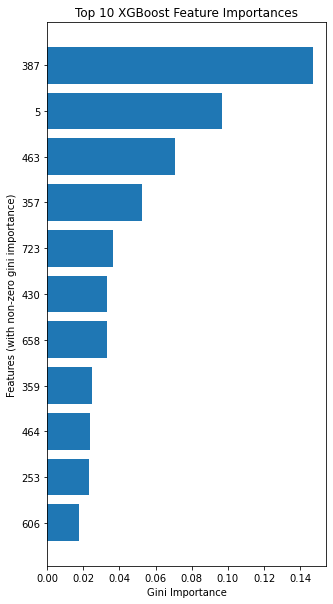

In [28]:
fig,ax = plt.subplots(figsize=(5,10))
plt.xlabel('Gini Importance')
plt.ylabel('Features (with non-zero gini importance)')
plt.barh(feature_importance['Feature'][121:], feature_importance['Importance'][121:])
plt.title('Top 10 XGBoost Feature Importances')

### Random Split PCA, DR, and Result Metrics

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Random Split Metrics:
Accuracy: 0.9497991967871486
Balanced Accuracy: 0.9032653061224489
ROC AUC: 0.9032653061224489
Precision Score: 0.9584352078239609
Recall Score: 0.98



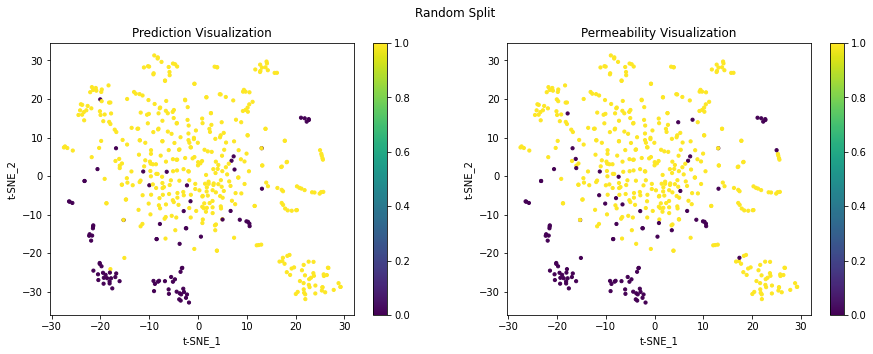

In [29]:
def plot_split(split, y_pred, y_test, t_components):
    
    fig = plt.figure(figsize=(15, 5))
    fig.suptitle('{} Split'.format(split))
    plt.subplot(1, 2, 1)
    plt.scatter(t_components[:,0], t_components[:,1], c=y_pred, s=10)
    plt.xlabel('t-SNE_1')
    plt.ylabel('t-SNE_2')
    plt.title('Prediction Visualization')
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.scatter(t_components[:,0], t_components[:,1], c=y_test,s=10)
    plt.xlabel('t-SNE_1')
    plt.ylabel('t-SNE_2')
    plt.title('Permeability Visualization')
    plt.colorbar()
    
    # Calculate how often the classifier is correct
    print("{} Split Metrics:".format(split))
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("Balanced Accuracy:", metrics.balanced_accuracy_score(y_test, y_pred))
    print("ROC AUC:", metrics.roc_auc_score(y_test, y_pred))
    print("Precision Score:", metrics.precision_score(y_test, y_pred))
    print("Recall Score:", metrics.recall_score(y_test, y_pred))
    print("")

dim = 100
pca_rand = PCA(n_components=dim)
components_rand = pca_rand.fit_transform(X_test)
tsne_rand = TSNE(n_components=2)
t_components_rand = tsne_rand.fit_transform(components_rand)

plot_split('Random', y_pred, y_test, t_components_rand)


### Scaffold Split 

#### Data preprocessing

In [30]:
Xs = bbb_df.iloc[:,3:].copy()
Ys = bbb_df.iloc[:,2].copy()
dataset = dc.data.DiskDataset.from_numpy(X=Xs,y=Ys,ids=bbb_df['SMILES'].tolist())
scaffoldsplitter = dc.splits.ScaffoldSplitter()
train_scaff, test_scaff = scaffoldsplitter.train_test_split(dataset)

### Model Predictions (Classes and Probabilities)

In [31]:
# Train Decision Tree classifier
xg_best = xg_best.fit(train_scaff.X,train_scaff.y)

# Predict the response for test dataset
y_pred_scaff = xg_best.predict(test_scaff.X)

In [32]:
y_pred_scaff_prob = xg_best.predict_proba(test_scaff.X)

prob_test_df = pd.DataFrame()
prob_test_df['SMILES'] = test_scaff.ids
prob_test_df['Prob Permeable'] = y_pred_scaff_prob[:,1]
prob_test_df = prob_test_df.sort_values(by=['Prob Permeable'], ascending=False)
prob_test_df

,SMILES,Prob Permeable
151,CC1CCCCC1(N1CCCCC1)c1sccc1,0.999998
25,Clc1ccccc1C1=NCc2nnc(n2c2sc(cc12)Br)C1CCCCC1,0.999998
65,CN1CCC(CC1)=C1c2ccsc2CCc2ccccc12,0.999997
62,C1CN2CCC1C(C2)N1c2ccccc2CCc2ccccc12,0.999995
111,CNCCCC1(C)CN(c2ccccc2)c2ccccc12,0.999993
...,...,...
204,CC[C@H](C(=O)NC/C=C/C=C(\C)/[C@@H](OC)[C@@H](C...,0.000094
246,CO\N=C(\C(=O)N[C@H]1[C@H]2SCC(=C(N2C1=O)C(O)=O...,0.000092
261,CCN1CCN(C(=O)N[C@@H](C(=O)N[C@H]2[C@H]3SCC(=C(...,0.000077
270,N[C@@H](C(=O)N[C@H]1[C@H]2SCC(=C(N2C1=O)C(O)=O...,0.000050


### Scaffold Split PCA, DR, and Result Metrics

In [33]:
dim = 100
pca_scaff = PCA(n_components=dim)
components_scaff = pca_scaff.fit_transform(test_scaff.X)

In [34]:
tsne_scaff = TSNE(n_components=2)
t_components_scaff = tsne_scaff.fit_transform(components_scaff)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Scaffold Split Metrics:
Accuracy: 0.8614457831325302
Balanced Accuracy: 0.8452555816686251
ROC AUC: 0.8452555816686251
Precision Score: 0.8026315789473685
Recall Score: 0.9945652173913043



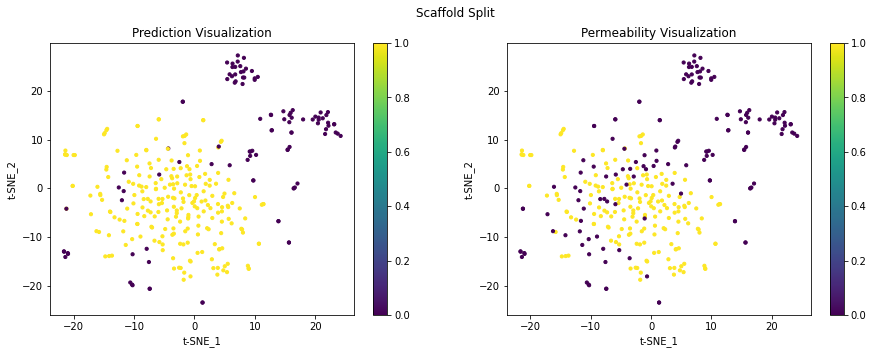

In [35]:
plot_split('Scaffold', y_pred_scaff, test_scaff.y, t_components_scaff)

## Scaffold Split Feature Importances

In [36]:
# get importance
dt_importance = xg_best.feature_importances_

# summarize and print out the feature importance
non_zero_index_list = [i for i, v in enumerate(dt_importance) if v != 0]

# remove all zero value entries
non_zero_feature_names = [bbb_df.iloc[:,3:].columns[i] for i in non_zero_index_list]
non_zero_importance = [dt_importance[i] for i in non_zero_index_list]
non_zero_feature_names_str = [str(x) for x in non_zero_feature_names]
feature_importance = pd.DataFrame(list(zip(non_zero_feature_names_str, non_zero_importance)), columns =['Feature','Importance'])
feature_importance.sort_values(by='Importance', ascending=True, inplace=True)

In [37]:
len(non_zero_importance)

109

Text(0.5, 1.0, 'Top 10 XGBoost Feature Importances')

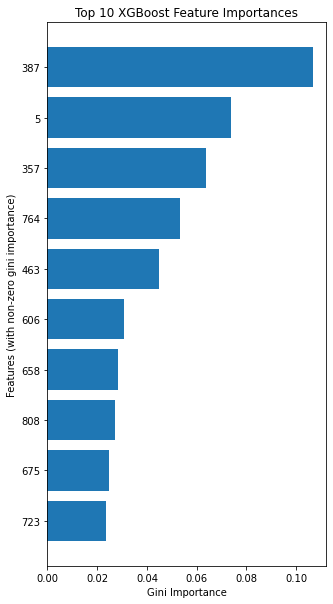

In [38]:
fig,ax = plt.subplots(figsize=(5,10))
plt.xlabel('Gini Importance')
plt.ylabel('Features (with non-zero gini importance)')
plt.barh(feature_importance['Feature'][-10:], feature_importance['Importance'][-10:])
plt.title('Top 10 XGBoost Feature Importances')

In [39]:
feature_importance['Importance'][-20:].tolist()

[0.013503183610737324,
 0.014889633283019066,
 0.015603496693074703,
 0.017803117632865906,
 0.01815555989742279,
 0.0195459071546793,
 0.02011752314865589,
 0.021557139232754707,
 0.021719837561249733,
 0.022954512387514114,
 0.023583069443702698,
 0.024666598066687584,
 0.02703344076871872,
 0.02854366973042488,
 0.030800338834524155,
 0.0448836013674736,
 0.05311009660363197,
 0.0638805478811264,
 0.07361932843923569,
 0.1067618876695633]

## K Fold Splits and MCC Calculations

In [40]:
def K_fold_MCC(dataset, h, split_name="Random Split", splitter=RandomSplitter()):
    
    split_data = splitter.k_fold_split(dataset, k=4)
    
    MCCs = []
    y_true = []
    h_predictions = []
    
    for data in split_data:
        h.fit(data[0].X, data[0].y)
        y_pred = h.predict(data[1].X)
        y_true.extend(list(data[1].y))
        h_predictions.extend(list(y_pred))
        mcc = matthews_corrcoef(data[1].y, y_pred)
        MCCs.append(mcc)
    
    print(split_name + " MCC Values:")
    
    for mcc in MCCs:
        print(mcc)
    print("Mean: " + str(np.mean(MCCs)))

    print("MCC value across full test data: " + str(matthews_corrcoef(y_true, h_predictions)))
    
    return MCCs

In [45]:
scaffoldsplitter = dc.splits.ScaffoldSplitter()

scaffold_split_mcc = K_fold_MCC(dataset, xg_best, 'Scaffold Split', scaffoldsplitter)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Scaffold Split MCC Values:
0.6515187123488106
0.811764902392185
0.35340999030727216
0.7561700932611006
Mean: 0.6432159245773421
MCC value across full test data: 0.7337132712263612


In [46]:
random_split_mcc = K_fold_MCC(dataset=dataset, h=xg_best)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random Split MCC Values:
0.778463210077747
0.8728987260488277
0.8657913314960837
0.8202596556550688
Mean: 0.8343532308194317
MCC value across full test data: 0.8328419997825265


In [47]:
print("T Test P-value: " + str(ttest_ind(scaffold_split_mcc, random_split_mcc).pvalue))

T Test P-value: 0.11711400589962877


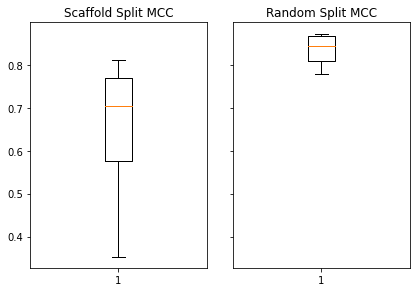

In [48]:
fig, ax = plt.subplots(1,2, sharey=True)
fig.tight_layout()

ax[0].boxplot(scaffold_split_mcc)
ax[0].title.set_text("Scaffold Split MCC")
ax[1].boxplot(random_split_mcc)
ax[1].title.set_text("Random Split MCC")